#**05. 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**

##**1) 장르 속성을 이용한 영화 콘텐츠 기반 필터링**

**(영화)콘텐츠 기반 필터링**
- 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것
- 영화(또는 상품/서비스) 간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감독, 배우 등)를 기반으로 하는 방식

  => 영화 장르 속성을 기반으로 콘텐츠 기반 필터링 시스템 구현 할 것임

  => 장르 칼럼 값의 유사도 비교 후 높은 평점을 가지는 영화를 추천하는 방식

##**2) 데이터 로딩 및 가공**

In [ ]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies =pd.read_csv('/content/drive/MyDrive/Euron7_ML/data/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


- 여러 칼럼이 존재하지만 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 새로운 DataFrame으로 생성
  - id
  - title : 영화 제목
  - genres : 영화가 속한 여러 장르
  - vote_average : 평균 평점
  - vote_count : 평점 투표 수
  - popularity : 영화의 인기
  - keywords : 영화 설명 주요 키워드 문구
  - overview : 영화 개요 설명

In [ ]:
movies_df = movies[['id','title', 'genres', 'vote_average', 'vote_count',
                 'popularity', 'keywords', 'overview']]

- genres, keywords 칼럼은 파이썬 리스트 내부에 딕셔너리가 있음

  => 칼럼 가공 필연적

In [ ]:
pd.set_option('max_colwidth', 100)
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


- 칼럼의 문자열을 분해해서 개별 장르를 파이썬 리스트 객체로 추출
  - 파이썬 ast모듈의 literal_eval()함수 이용
  - Series 객체의 apply()에 literal_eval()함수를 적용해 문자열을 객체로 변환

In [ ]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

- 칼럼에서 'name'키에 해당하는 값만 추출 -> apply lambda식 이용

In [ ]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


##**3) 장르 콘텐츠 유사도 측정**

- 장르별 유사도 측정 방법
  - genres를 문자열로 변경한 뒤, CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교
- genres 칼럼 기반 콘텐츠 기반 필터링 구현 단계
  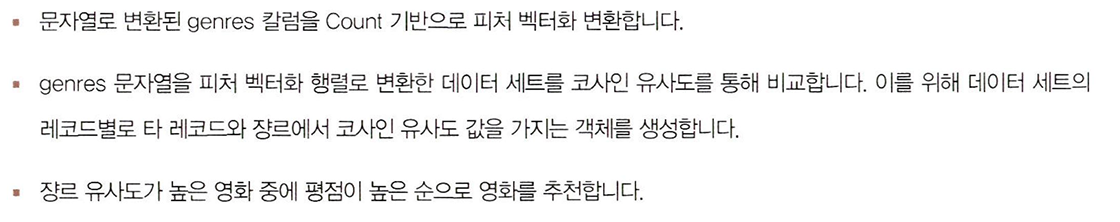

- genres 칼럼을 apply를 적용해 개별 요소를 공백 문자로 구분하는 문자열로 변환해 별도의 칼럼인 genres_listeral칼럼으로 저장
  - 리스트 객체 내의 개별 값을 연속된 문자열로 변환하려면 일반적으로 ('구분문자').join(리스트 객체)를 사용

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0.0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


- 사이킷런의 cosine_similarity()를 이용해 코사인 유사도 계산
  - cosine_similarity() : 기준 행과 비교 행의 유사도를 행렬 형태로 반환하는 함수
  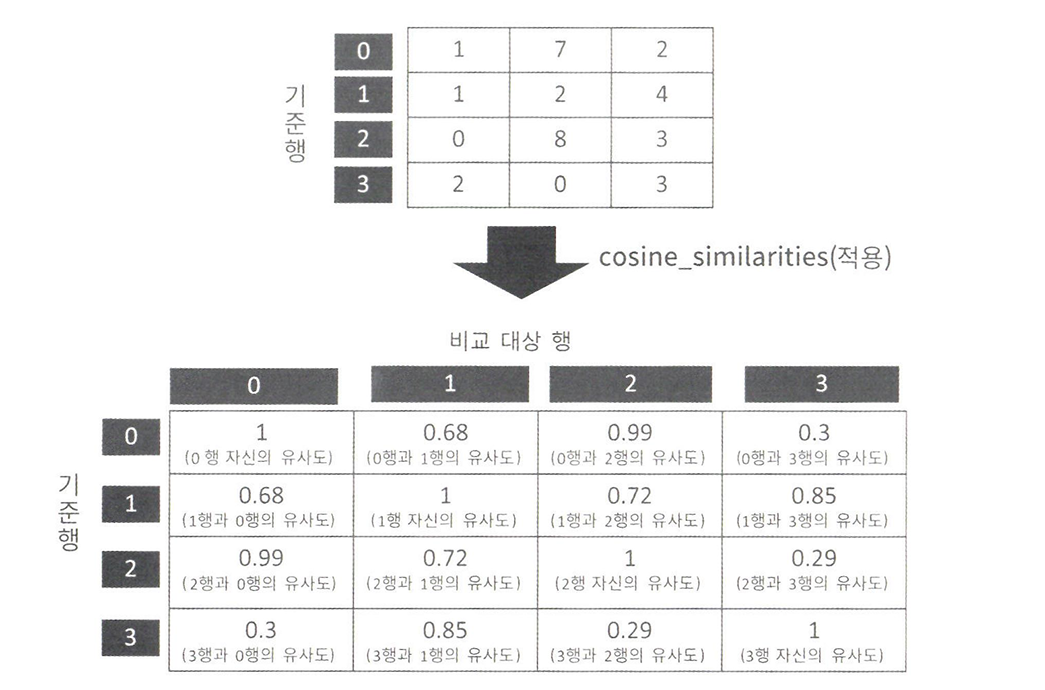

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


- genre_sim객체는 movies_df의 genre_literal칼럼을 피처 벡터화한 행렬(genre_mat) 데이터의 행별 유사도 정보를 가짐
  
  => movies_df DataFrame의 행별 장르 유사도 값

- genre_sim객체의 기준 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 추출

  => 값이 높은 순으로 정렬된 비교 대상 행의 유사도 값 X, 비교 대상 행의 위치 인덱스 O

In [ ]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


- genre_sim_sorted_ind : 각 레코드의 장르 코사인 유사도가 가장 높은 순으로 정렬된 타레코드의 위치 인덱스 값을 가짐

##**4) 장르 콘텐츠 필터링을 이용한 영화 추천**

- find_sim_movie()생성 : 장르 유사도에 따라 영화를 추천하는 함수

In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):

    # 인자로 입력된 movies_df DataFrame에서 'title' 컬럼이 입력된 title_name 값인 DataFrame추출
    title_movie = df[df['title'] == title_name]

    # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n 개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]

    # 추출된 top_n index들 출력. top_n index는 2차원 데이터임.
    # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)

    return df.iloc[similar_indexes]

In [ ]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


- 더 많은 후보군 선정 후 영화의 평점에 따라 필터링해서 최종 추천 방식으로 변경
  - 영화의 평점 정보 'vote_average'값 이용

   => 소수 관객이 특정 영화에 만점이나 매우 높은 평점을 부여해 왜곡된 데이터를 가짐


In [ ]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


- 유명 영화 평점 사이트 IMDB에서 평가 횟수에 대한 가중치가 부여된 평점 방식을 사용, 이 방식을 이용하여 새롭게 평점 부여
  - 가중 평점 공식
    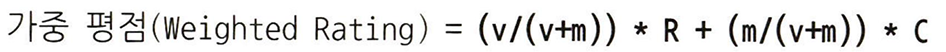

  - 각 변수의 의미
  
    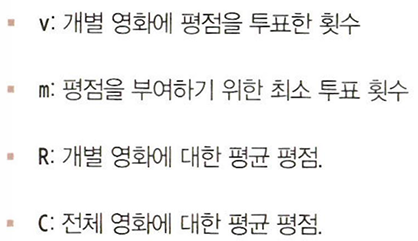

- m : 투표 횟수에 따른 가중치를 직접 조절하는 역할, m값을 높이면 평점 투표 횟수가 많은 영화에 더 많은 가중 평점 부여

  => m값은 전체 투표 횟수에서 상위 60%에 해당하는 횟수 기준

In [ ]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:',round(C,3), 'm:',round(m,3))

C: 6.092 m: 370.2


In [ ]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']

    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1)

In [ ]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',
                                                                          ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


- 장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정한 뒤에 weighted_vote 칼럼 값이 높은 순으로 top_n만큼 추출하는 방식으로 find_sim_movie()함수를 변경

In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values

    # top_n의 2배에 해당하는 쟝르 유사성이 높은 인덱스 추출
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
    # 기준 영화 인데스는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]

    # top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n 만큼 추출
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


#**06. 아이템 기반 최근접 이웃 협업 필터링 실습**

##**1) 데이터 가공 및 변환**

In [2]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/Euron7_ML/data/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Euron7_ML/data/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


- movies.csv : 영화에 대한 메타 정보인 title과 genres를 갖고 있는 영화 정보
- ratings.csv : 사용자별 영화에 대한 평점을 매긴 데이터 세트

  => 이 데이터 세트 이용해 아이템 기반의 최근접 이웃 협업 필터링 구현


- 모든 사용자를 로우로, 모든 영화를 칼럼으로 구성한 데이터 세트로 변경
  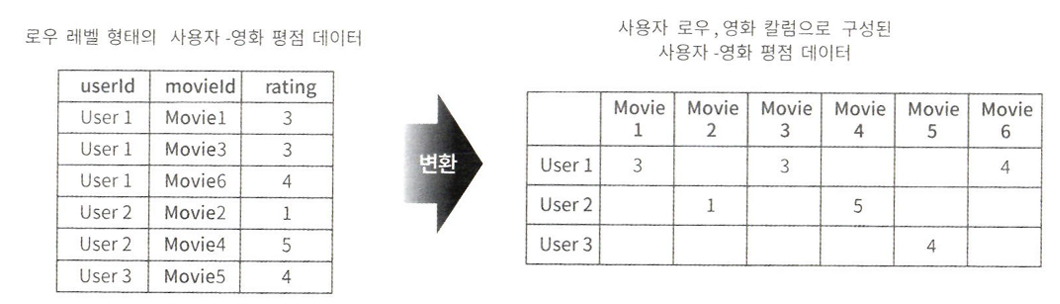

  => pivot_tabel()함수 이용

In [3]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- NaN이 많음 -> 사용자가 평점을 매기지 않은 영화가 칼럼으로 변환되면서 NaN으로 할당 됨

In [4]:
# title 컬럼을 얻기 이해 movies와 조인
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##**2) 영화 간 유사도 산출**

- 현재 rating_matrix데이터 세트에 cosine_similarity()함수를 적용하면 영화간 유사도 측정 불가 -> userID가 기준인 행 레벨 데이터이기 때문
  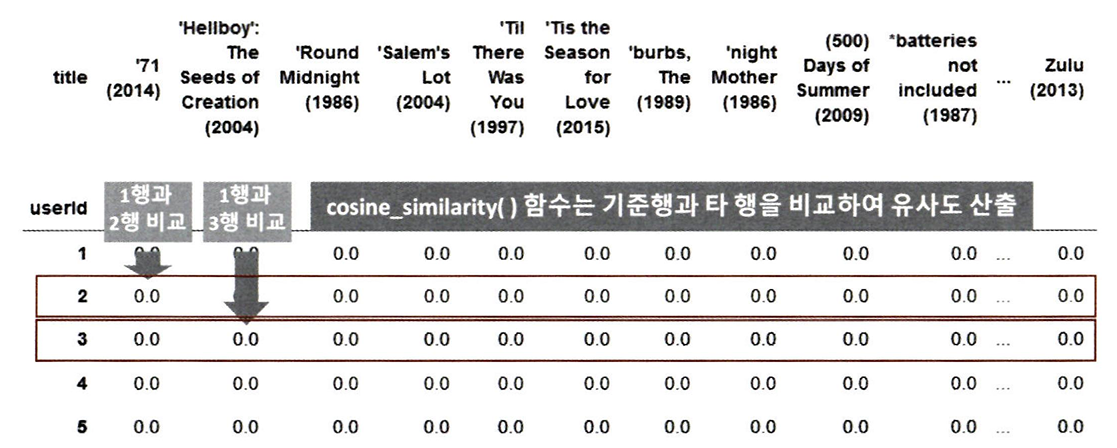

In [5]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 영화명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                          columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [7]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

,"Godfather, The (1972)"
title,
"Godfather, The (1972)",1.000000
"Godfather: Part II, The (1974)",0.821773
Goodfellas (1990),0.664841
One Flew Over the Cuckoo's Nest (1975),0.620536
Star Wars: Episode IV - A New Hope (1977),0.595317
Fargo (1996),0.588614


In [8]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

,Inception (2010)
title,
"Dark Knight, The (2008)",0.727263
Inglourious Basterds (2009),0.646103
Shutter Island (2010),0.617736
"Dark Knight Rises, The (2012)",0.617504
Fight Club (1999),0.615417


##**3) 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천**

- 영화 유사도 데이터를 이용해 최근접 이웃 협업 필터링으로 개인에게 최적화된 영화 추천 구현
- 가장 큰 특징 : 개인이 아직 관람하지 않은 영화를 추천
- 높은 예측 평점을 가진 영화를 추천하는 방식
  - 개인화된 예측 평점 구하는 식
    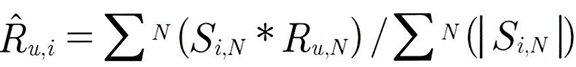
    
    - 변수의 의미
    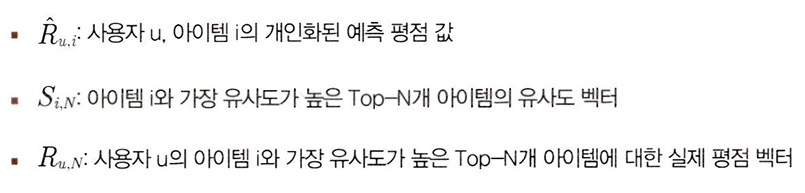

      - N값은 최근접 이웃 범위 계수를 의미

In [9]:
def predict_rating(ratings_arr, item_sim_arr ):
    ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [10]:
ratings_pred = predict_rating(ratings_matrix.values , item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


- 예측 평점이 사용자별 영화의 실제 평점과 영화의 코사인 유사도를 내적한 값이기 때문에 기존 영화를 관람하지 않아 0에 해당했던 실제 영화 평점이 예측에서는 값이 부여되는 경우가 많음
  - 예측 평점이 실제 평점에 비해 작을 수 있음
    (내적 결과를 코사인 유사도 벡터 합으로 나누었기 때문에 생기는 현상)

In [12]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 를 구함
def get_mse(pred, actual):
    # 평점이 있는 실제 영화만 추출
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))

아이템 기반 모든 최근접 이웃 MSE:  9.895354759094706


In [13]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬 인덱스 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
    return pred

- 데이터 크기가 커지면 수행 시간이 매우 오래 걸릴 수 있다는 단점이 있음

In [14]:
ratings_pred = predict_rating_topsim(ratings_matrix.values , item_sim_df.values, n=20)
print('아이템 기반 인접 TOP-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))


# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

<ipython-input-13-6a540ad987a4>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)


아이템 기반 인접 TOP-20 이웃 MSE:  3.6949827608772314


- MSE가 기존보다 많이 향상됨

In [15]:
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[ user_rating_id > 0].sort_values(ascending=False)[:10]

,9
title,
Adaptation (2002),5.0
Citizen Kane (1941),5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),5.0
"Producers, The (1968)",5.0
"Lord of the Rings: The Two Towers, The (2002)",5.0
"Lord of the Rings: The Fellowship of the Ring, The (2001)",5.0
Back to the Future (1985),5.0
Austin Powers in Goldmember (2002),5.0
Minority Report (2002),4.0


- 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록 함수 생성

In [16]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함
    # 반환된 user_rating 은 영화명(title)을 인덱스로 가지는 Series 객체임
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출하여 list 객체로 만듦
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듦
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [17]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 컬럼을 추출해
    # 가장 예측 평점이 높은 순으로 정렬함
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


#**07. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습**

- SGD 기반의 행렬 분해를 구현한 후 이를 기반으로 사용자에게 영화 추천

In [20]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    prev_rmse = 10000
    break_count = 0

    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

    return P, Q

- 영화 평점 행렬 데이터를 새롭게 DataFrame으로 로딩한 뒤, 다시 사용자-아이템 평점 행렬로

In [22]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/Euron7_ML/data/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Euron7_ML/data/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

- matrix_fatorization()함수를 이용해 행렬 분해

In [23]:
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

- 반환된 예측 사용자-아이템 평점 행렬을 영화 타이틀 칼럼명을 갖는 DataFrame으로 변경

In [24]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


- 예측 사용자-아이템 평점 행렬 정보를 이용해 개인화된 영화 추천

In [27]:
# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,
                             columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


- 앞절의 아이템 기반 협업 필터링 결과와 많이 다름